In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
import os
import random
from IPython.display import display
from matplotlib import image

In [40]:
def data_analysis_histogram(dir_path):
    classes = os.listdir(dir_path)
    class_dist = []
    for c in classes:
        class_path = os.path.join(dir_path,c)
        class_dist.append(len(os.listdir(class_path)))
    plt.figure(figsize=(16, 8))
    plt.title("Class distribution")
    plt.barh(classes, class_dist)
    for index, value in enumerate(class_dist):
        plt.text(value, index,str(value))
    plt.show()

def data_analysis_image_size(dir_path, seed):
    classes = os.listdir(dir_path)
    if seed>=0:
        random.seed(seed)
    random_class_path = os.path.join(dir_path,random.choice(classes))
    random_img_name = random.choice(os.listdir(random_class_path))
    random_img_path = os.path.join(random_class_path,random_img_name)
    img = image.imread(random_img_path)
    plt.figure(figsize=(16, 8))
    plt.title("%s - Height: %d px x Length: %d px" % (random_img_path,img.shape[0],img.shape[1]))
    plt.imshow(img)

def analyse_dataset(dir_path, seed = -1):
    data_analysis_histogram(dir_path)
    data_analysis_image_size(dir_path, seed)


In [41]:
def load_dataset(dir_path, seed = 42):
    random.seed(seed)
    classes = os.listdir(dir_path)
    for c in classes:
        class_path = os.path.join(dir_path,c)
        imgs_name = os.listdir(class_path)
        img_path_and_class = []
        for i in imgs_name:
            img_path_and_class.append([image.imread(os.path.join(class_path,i)),c])
    
    random.shuffle(img_path_and_class)
    img_path_and_class = np.array(img_path_and_class,dtype=object)
    return img_path_and_class[:,0], img_path_and_class[:,1]

In [42]:
def split_dataset(x, y = None, val_size = 0.2):
    if val_size <= 0 or val_size >= 1:
        raise ValueError('Parameter val_size must be between 0 and 1')
    
    x_train_len = int(x.shape[0]*(1-val_size))
    x_train = x[0:x_train_len]
    y_train = x[x_train_len:]
    if y is None:
        return x_train, y_train
    else:
        y_train_len = int(y.shape[0]*(1-val_size))
        x_val = y[0:y_train_len]
        y_val = y[y_train_len:]
        return x_train, y_train, x_val, y_val


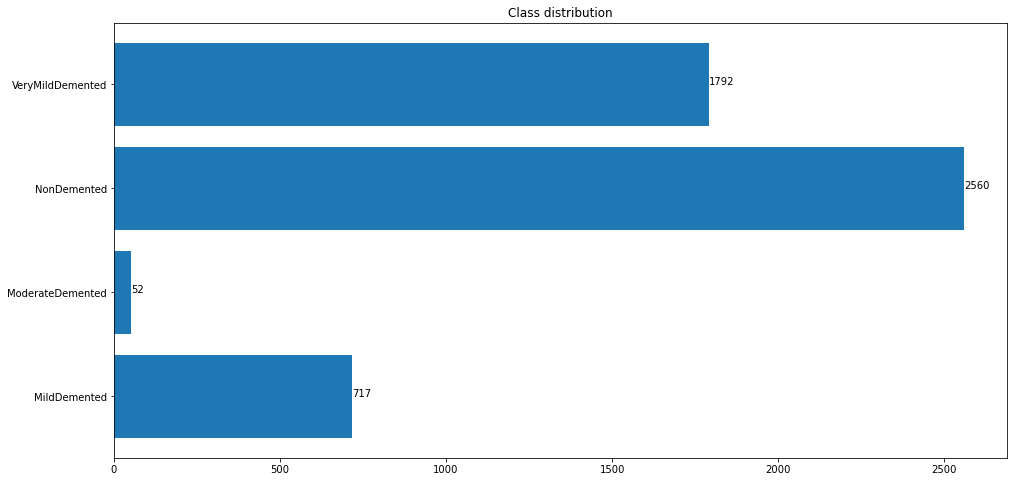

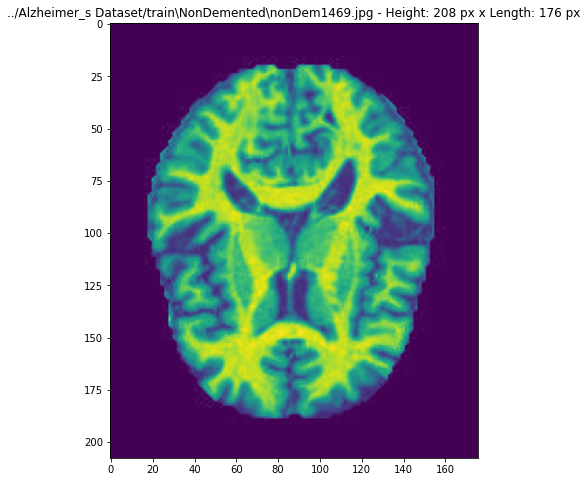

In [45]:
analyse_dataset('../Alzheimer_s Dataset/train')

In [46]:
xTrainVal, yTrainVal = load_dataset('../Alzheimer_s Dataset/train')
#xTest, yTest = load_images('../Alzheimer_s Dataset/test')
x_train, y_train, x_val, y_val = split_dataset(xTrainVal, yTrainVal,val_size=0.2)